# Import packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

# Read CSV file

In [2]:
df = pd.read_csv('Data/Clean_Dataset.csv')

# Set styles and sizes

In [3]:
sns.set_theme(style="whitegrid", font="Arial")
plt.rcParams['figure.facecolor'] = 'white'
palette = sns.color_palette("deep", 10)
sns.set_palette(palette)
plt.rcParams['figure.dpi'] = 300

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Data Cleaning

In [4]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [6]:
df = df.drop(['Unnamed: 0'], axis=1)

In [7]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


# EDA

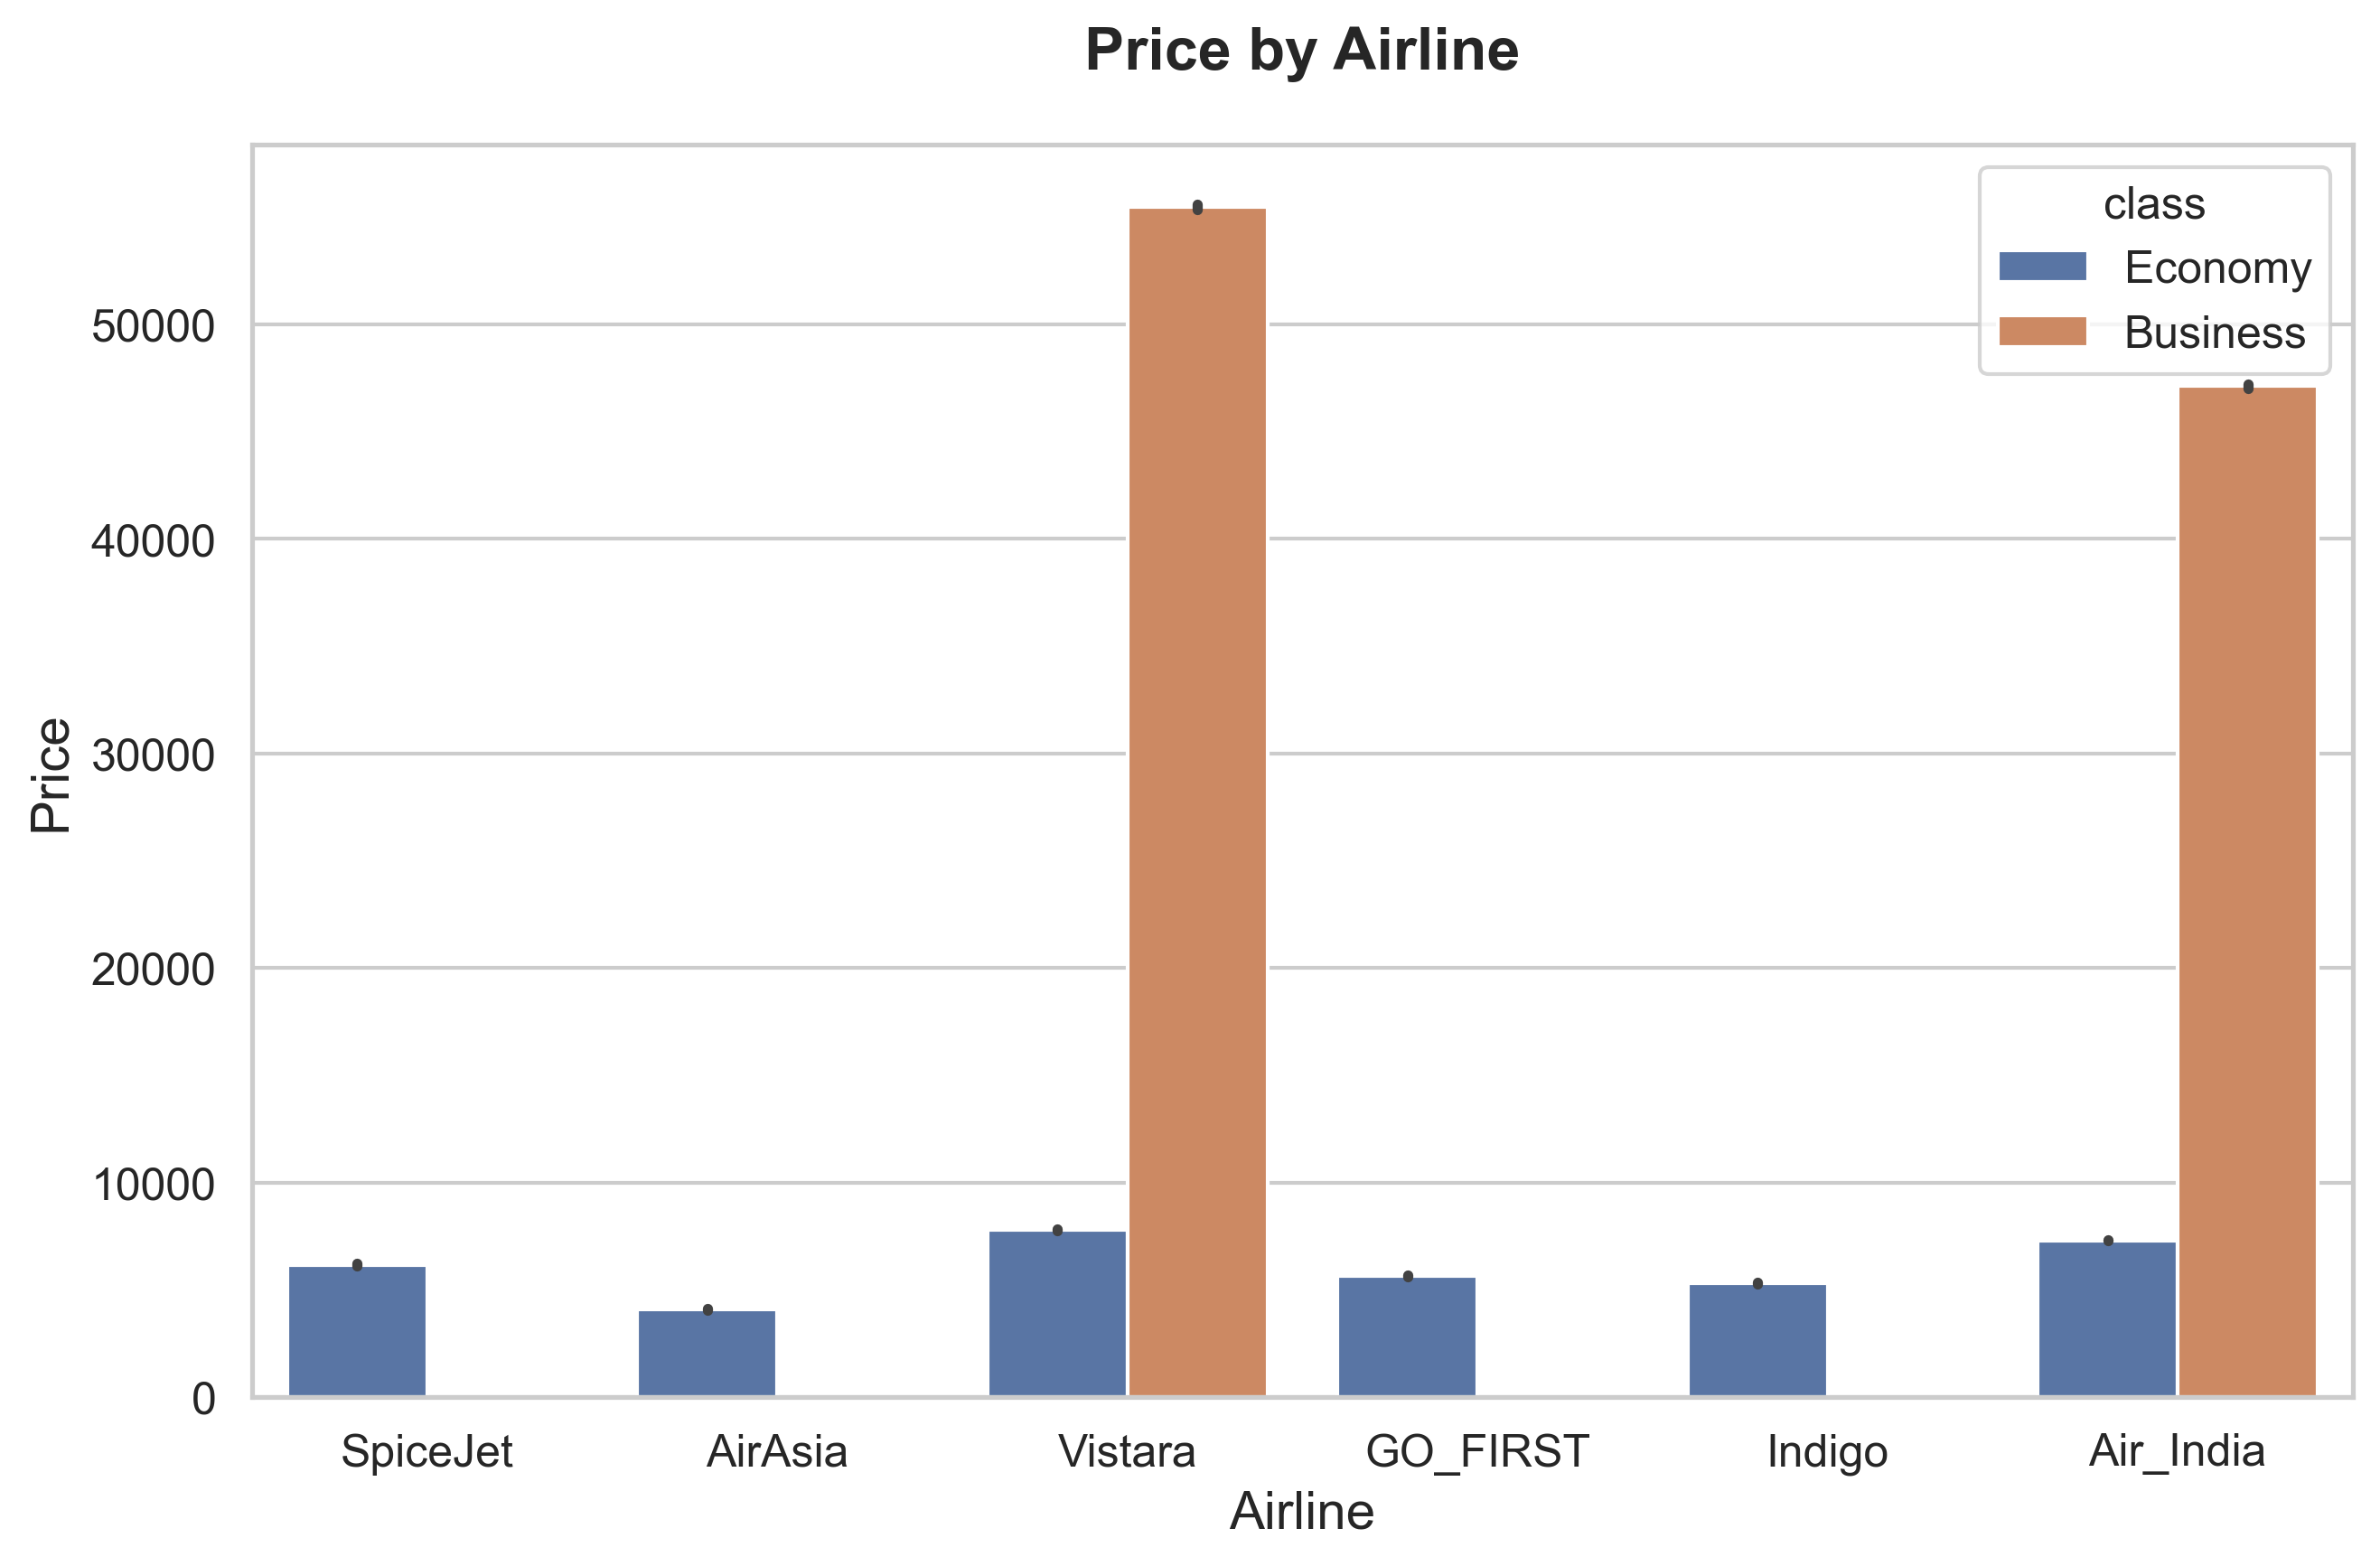

In [8]:
# Plot price by airlines
sns.barplot(x='airline',y='price', data=df, hue = df['class'])
plt.title('Price by Airline', fontweight='bold', pad =20)
plt.xlabel('Airline')
plt.ylabel('Price')
plt.savefig('Images/price_by_airline', dpi=300)
plt.show()

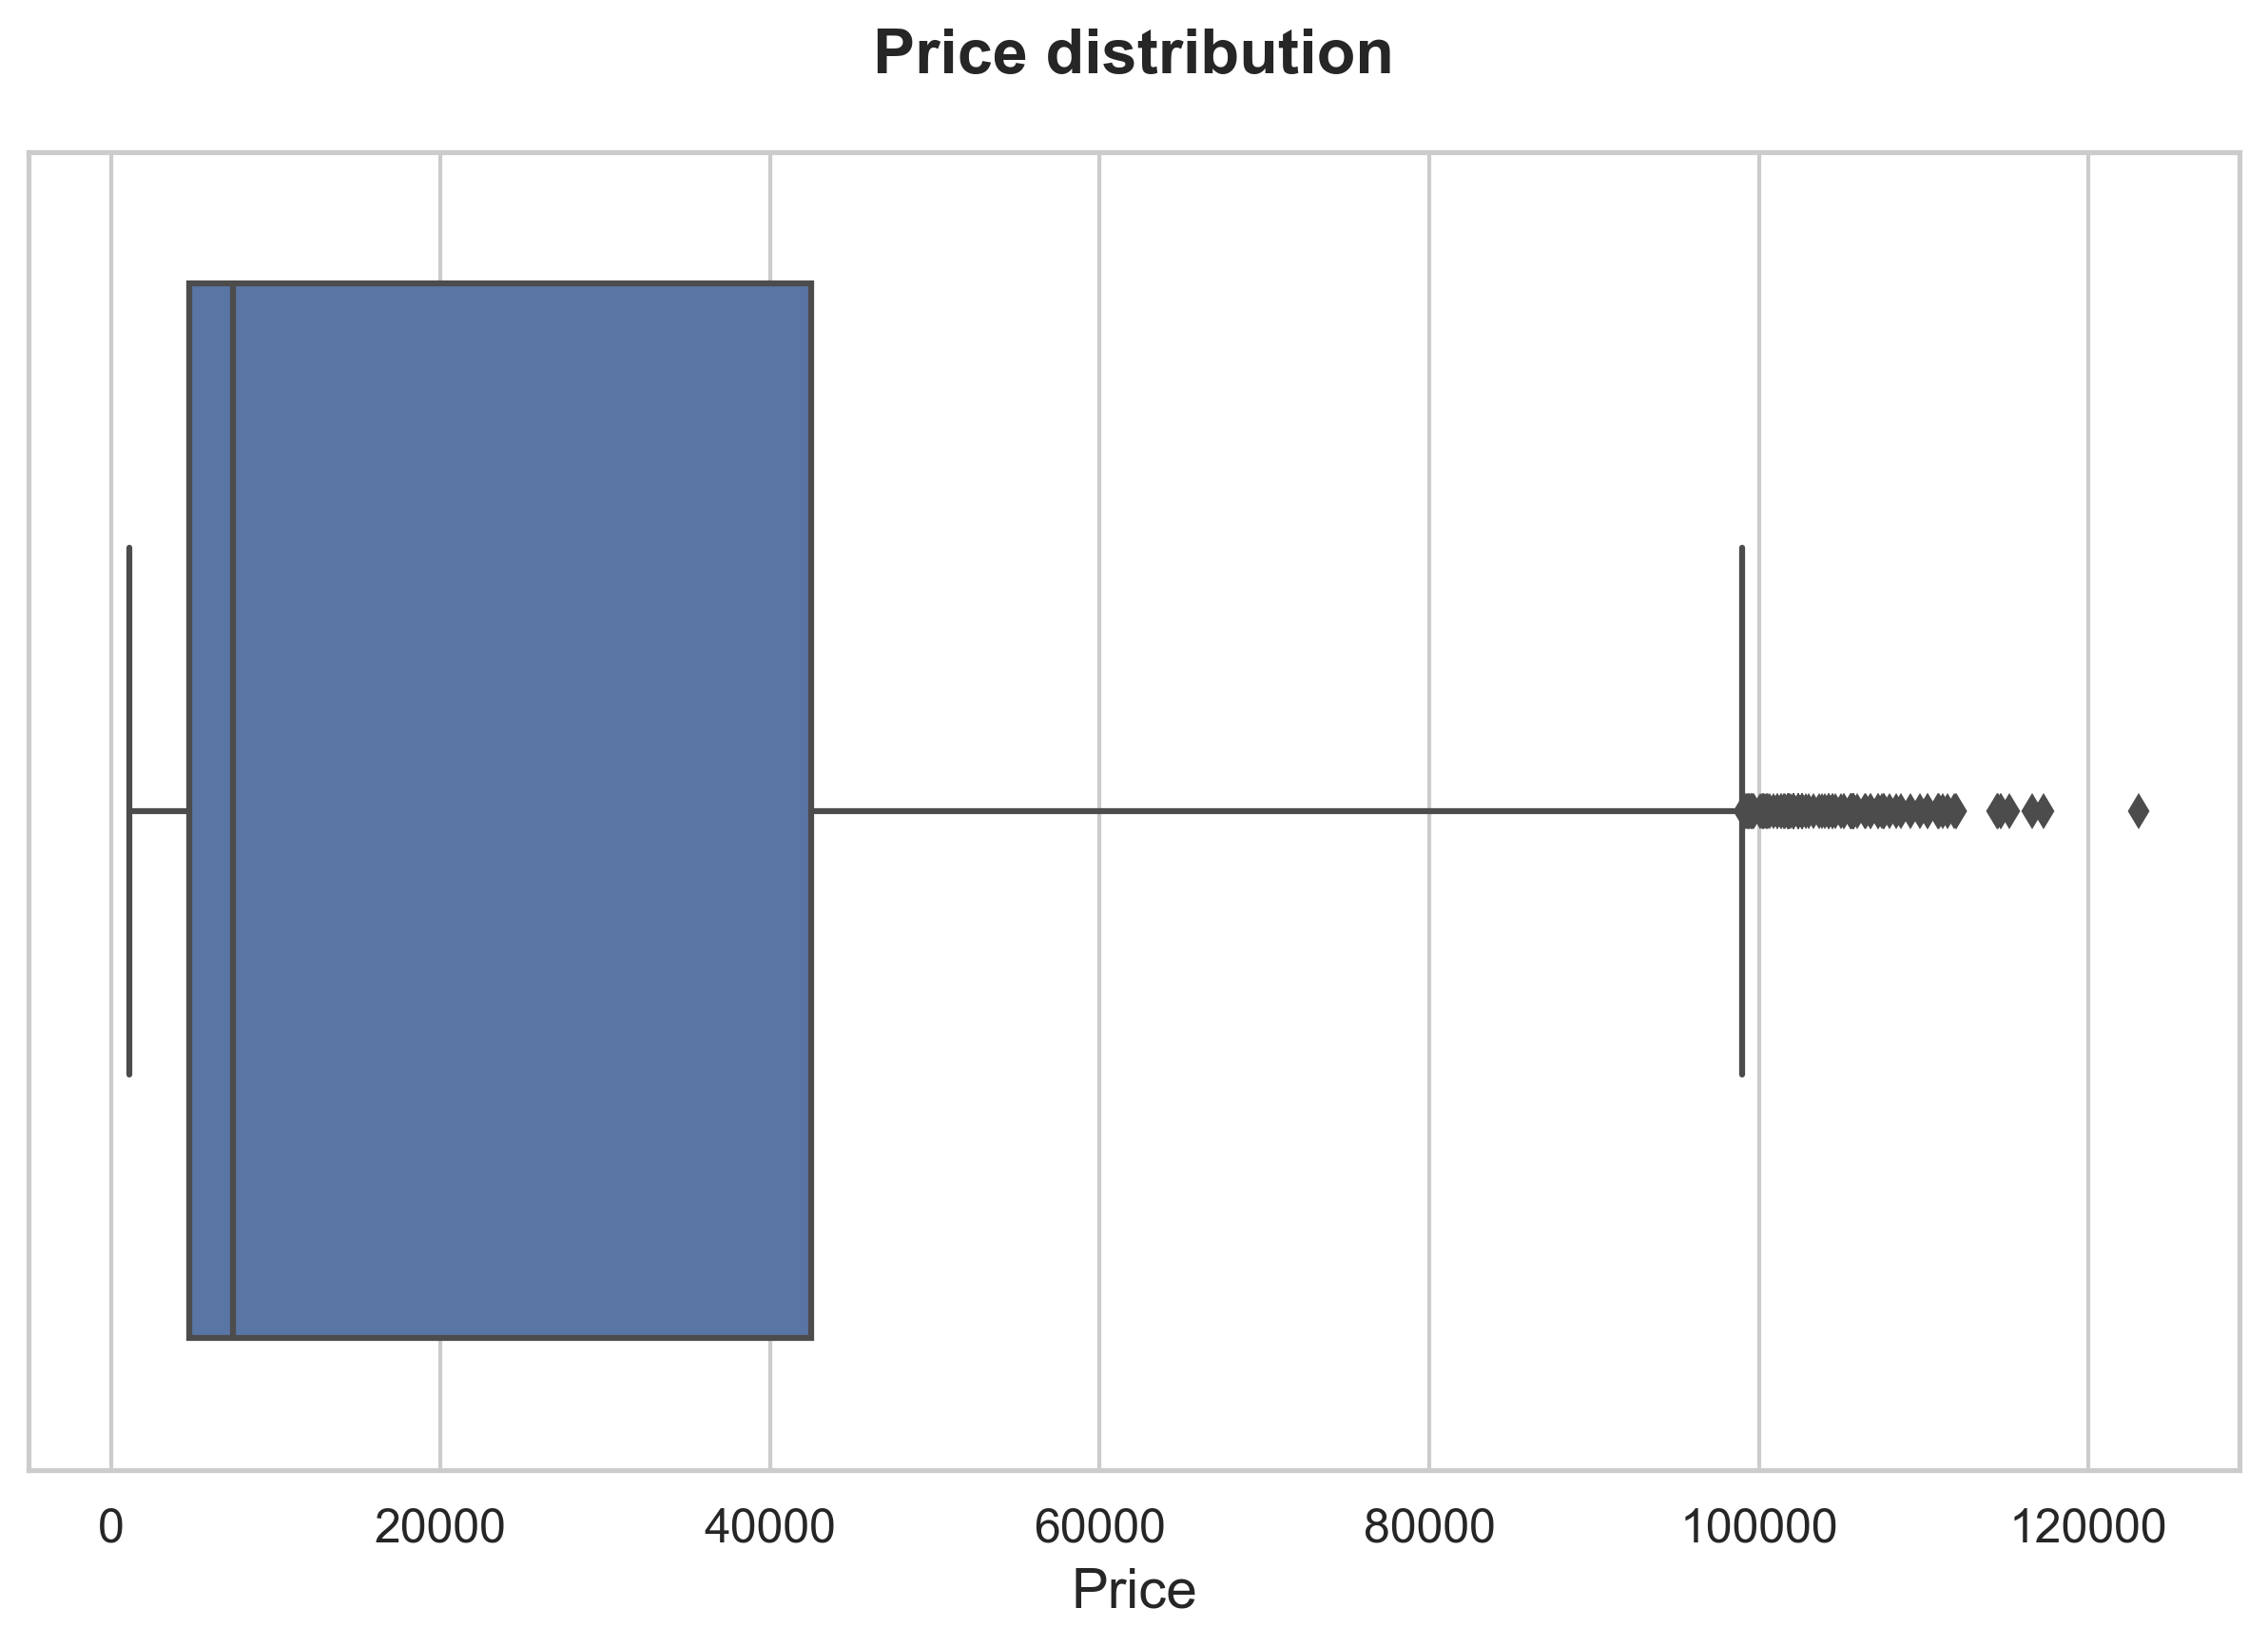

In [9]:
# Price distribution
sns.boxplot(df, x = df.price)
plt.title('Price distribution', fontweight='bold', pad =20)
plt.xlabel('Price')
plt.savefig('Images/price_distribution', dpi=300)
plt.show()

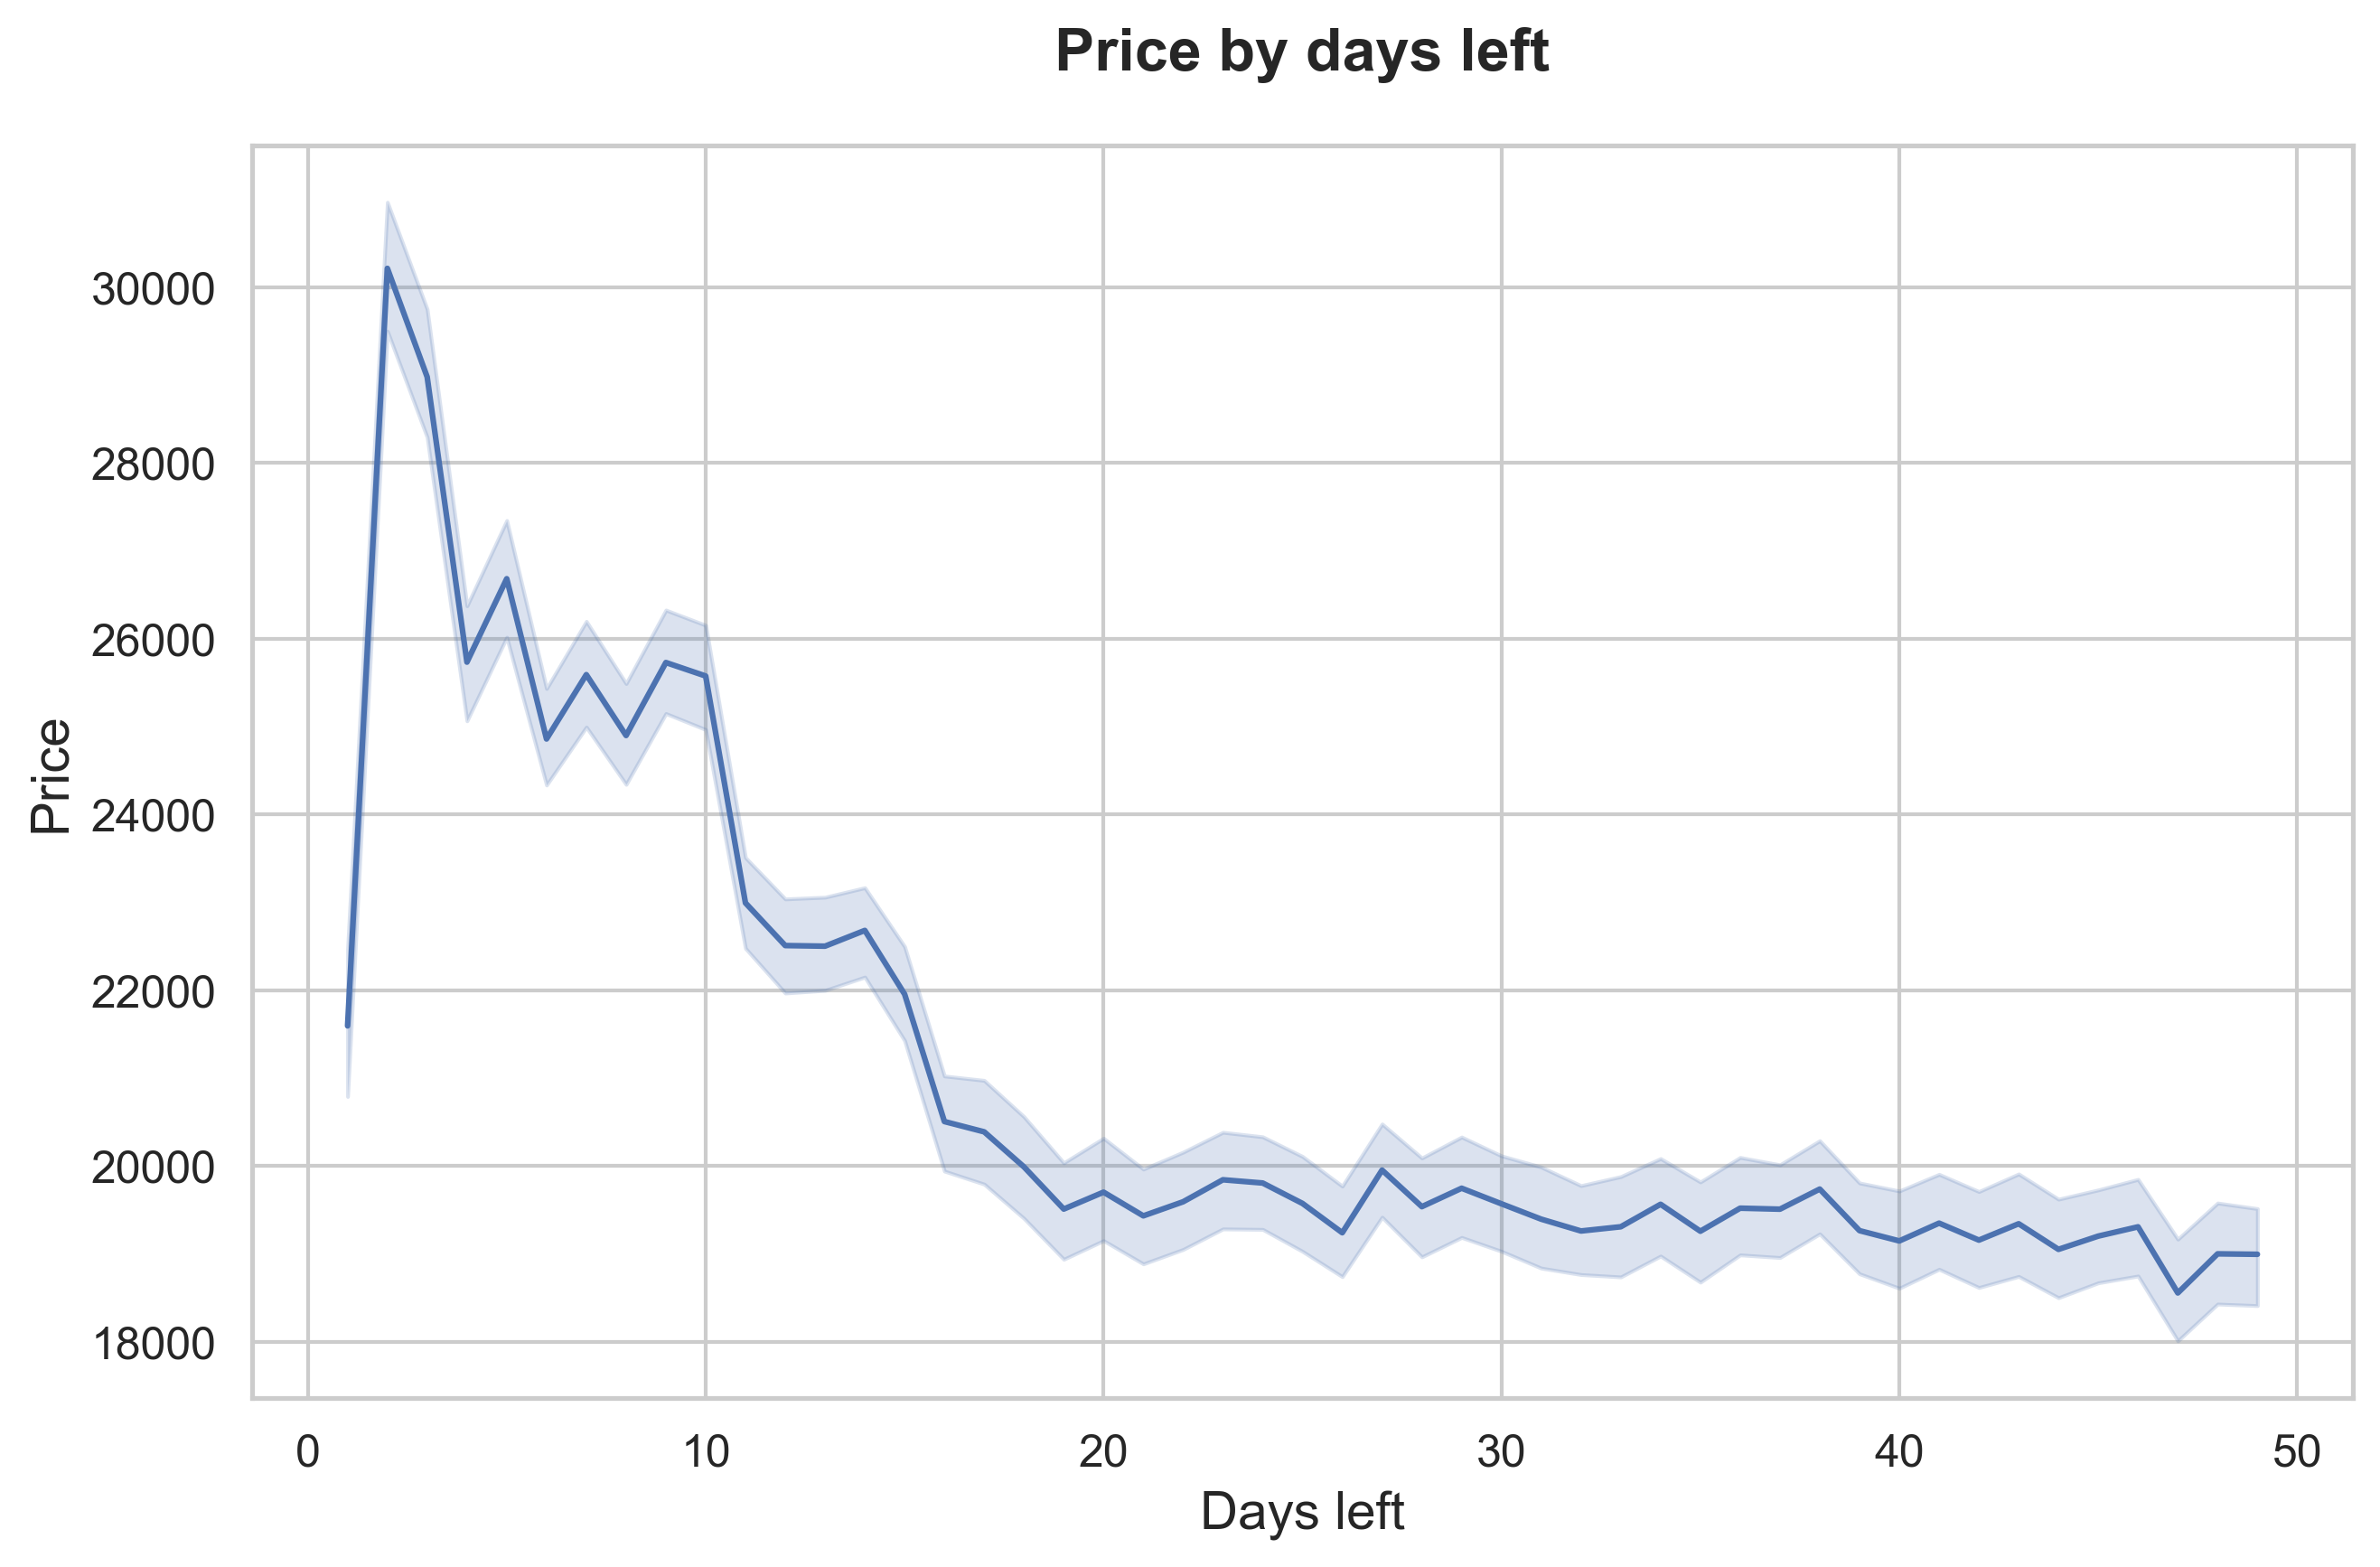

In [10]:
# Plot price by days left
sns.lineplot(x='days_left',y='price' ,data=df)
plt.title('Price by days left', fontweight='bold', pad =20)
plt.xlabel('Days left')
plt.ylabel('Price')
plt.savefig('Images/price_by_days_left', dpi=300)
plt.show()

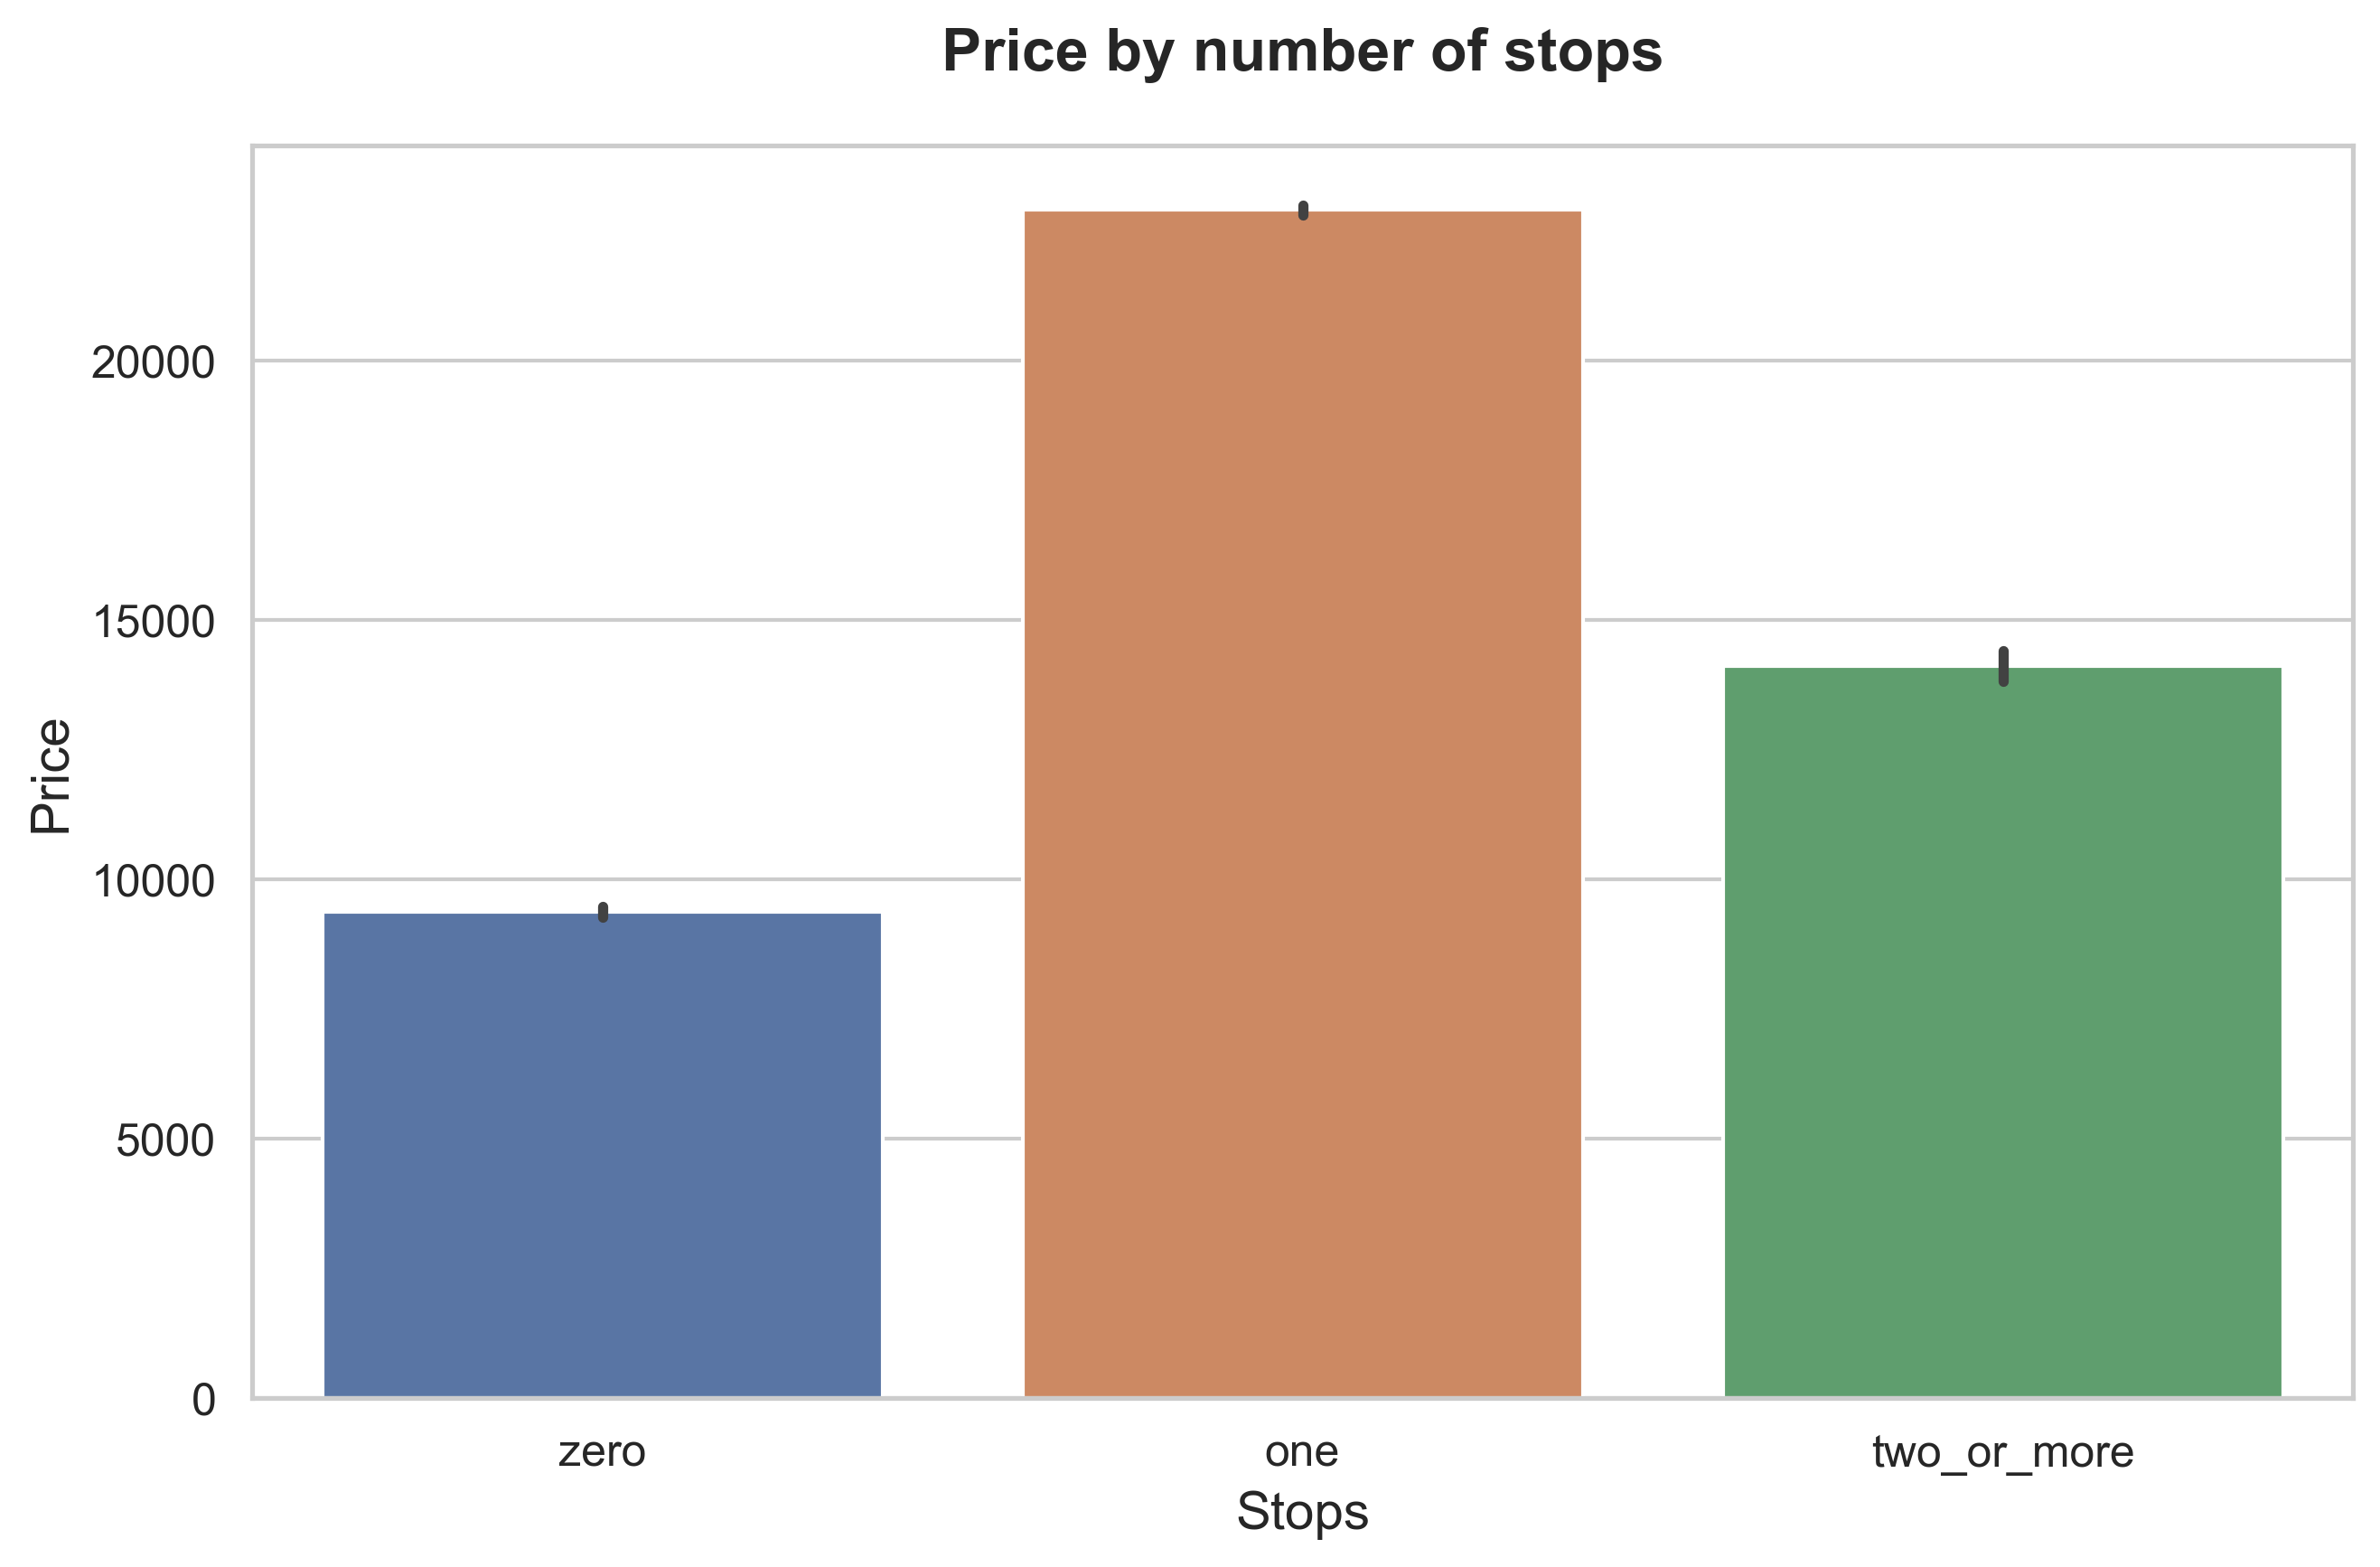

In [11]:
# Number of stops effect on price
sns.barplot(x='stops', y='price', data=df)
plt.title('Price by number of stops', fontweight='bold', pad =20)
plt.xlabel('Stops')
plt.ylabel('Price')
plt.savefig('Images/price_by_number_of_stops', dpi=300)
plt.show()

# Preprocess data for ML

In [12]:
# Understand how many unique values the columns have
def show_non_numeric_value_counts(df):
    for column in df.columns:
        if not np.issubdtype(df[column].dtype, np.number):
            print(f"\nValue counts: {column}")
            print(df[column].value_counts())
            print("-" * 50)

show_non_numeric_value_counts(df)


Value counts: airline
airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64
--------------------------------------------------

Value counts: flight
flight
UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: count, Length: 1561, dtype: int64
--------------------------------------------------

Value counts: source_city
source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64
--------------------------------------------------

Value counts: departure_time
departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64
-------------------------------------

In [13]:
# Since there is only 6 airlines, 6 source cities, 6 destination citites, 6 departure and arrival timeslots, 3 values for stops it can be usefull to one hot encode them

In [14]:
# Understand duration column
df['duration'].describe()

count    300153.000000
mean         12.221021
std           7.191997
min           0.830000
25%           6.830000
50%          11.250000
75%          16.170000
max          49.830000
Name: duration, dtype: float64

In [15]:
# Change the dataframe by:
# - Turn the following columns to numerical values: stops, class
# - One hot encode columns: airline, source_city, departure_time, arrival_time, destination_city
# - Droping columns that will not be needed

df['class'] = df['class'].apply(lambda x: 1 if x == 'Business' else 0)
df['stops'] = df['stops'].apply(lambda x: 2 if x == 'two_or_more' else (1 if x == 'one' else 0))

df = df.join(pd.get_dummies(df.airline, prefix = 'airline').astype(int))
df = df.join(pd.get_dummies(df.source_city, prefix = 'source').astype(int))
df = df.join(pd.get_dummies(df.destination_city, prefix = 'destination').astype(int))
df = df.join(pd.get_dummies(df.arrival_time, prefix = 'arrival_time').astype(int))
df = df.join(pd.get_dummies(df.departure_time, prefix = 'departure_time').astype(int))

df = df.drop(['flight', 'airline', 'source_city', 'destination_city', 'arrival_time', 'departure_time'], axis=1)
df.head()

,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,...,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night
0,0,0,2.17,1,5953,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
1,0,0,2.33,1,5953,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
2,0,0,2.17,1,5956,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,2.25,1,5955,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,2.33,1,5955,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


# Random forest model

In [16]:
X, y = df.drop('price' , axis = 1), df.price

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [18]:
reg = RandomForestRegressor(n_jobs=-1)
reg.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [19]:
# Calculate the precision of the model
y_pred = reg.predict(X_test)
print("R^2 Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", math.sqrt(mean_squared_error(y_test, y_pred)))

R^2 Score: 0.9853964168924558
Mean Absolute Error: 1068.8983084130077
Mean Squared Error: 7535327.606278713
Root Mean Squared Error: 2745.055118987361


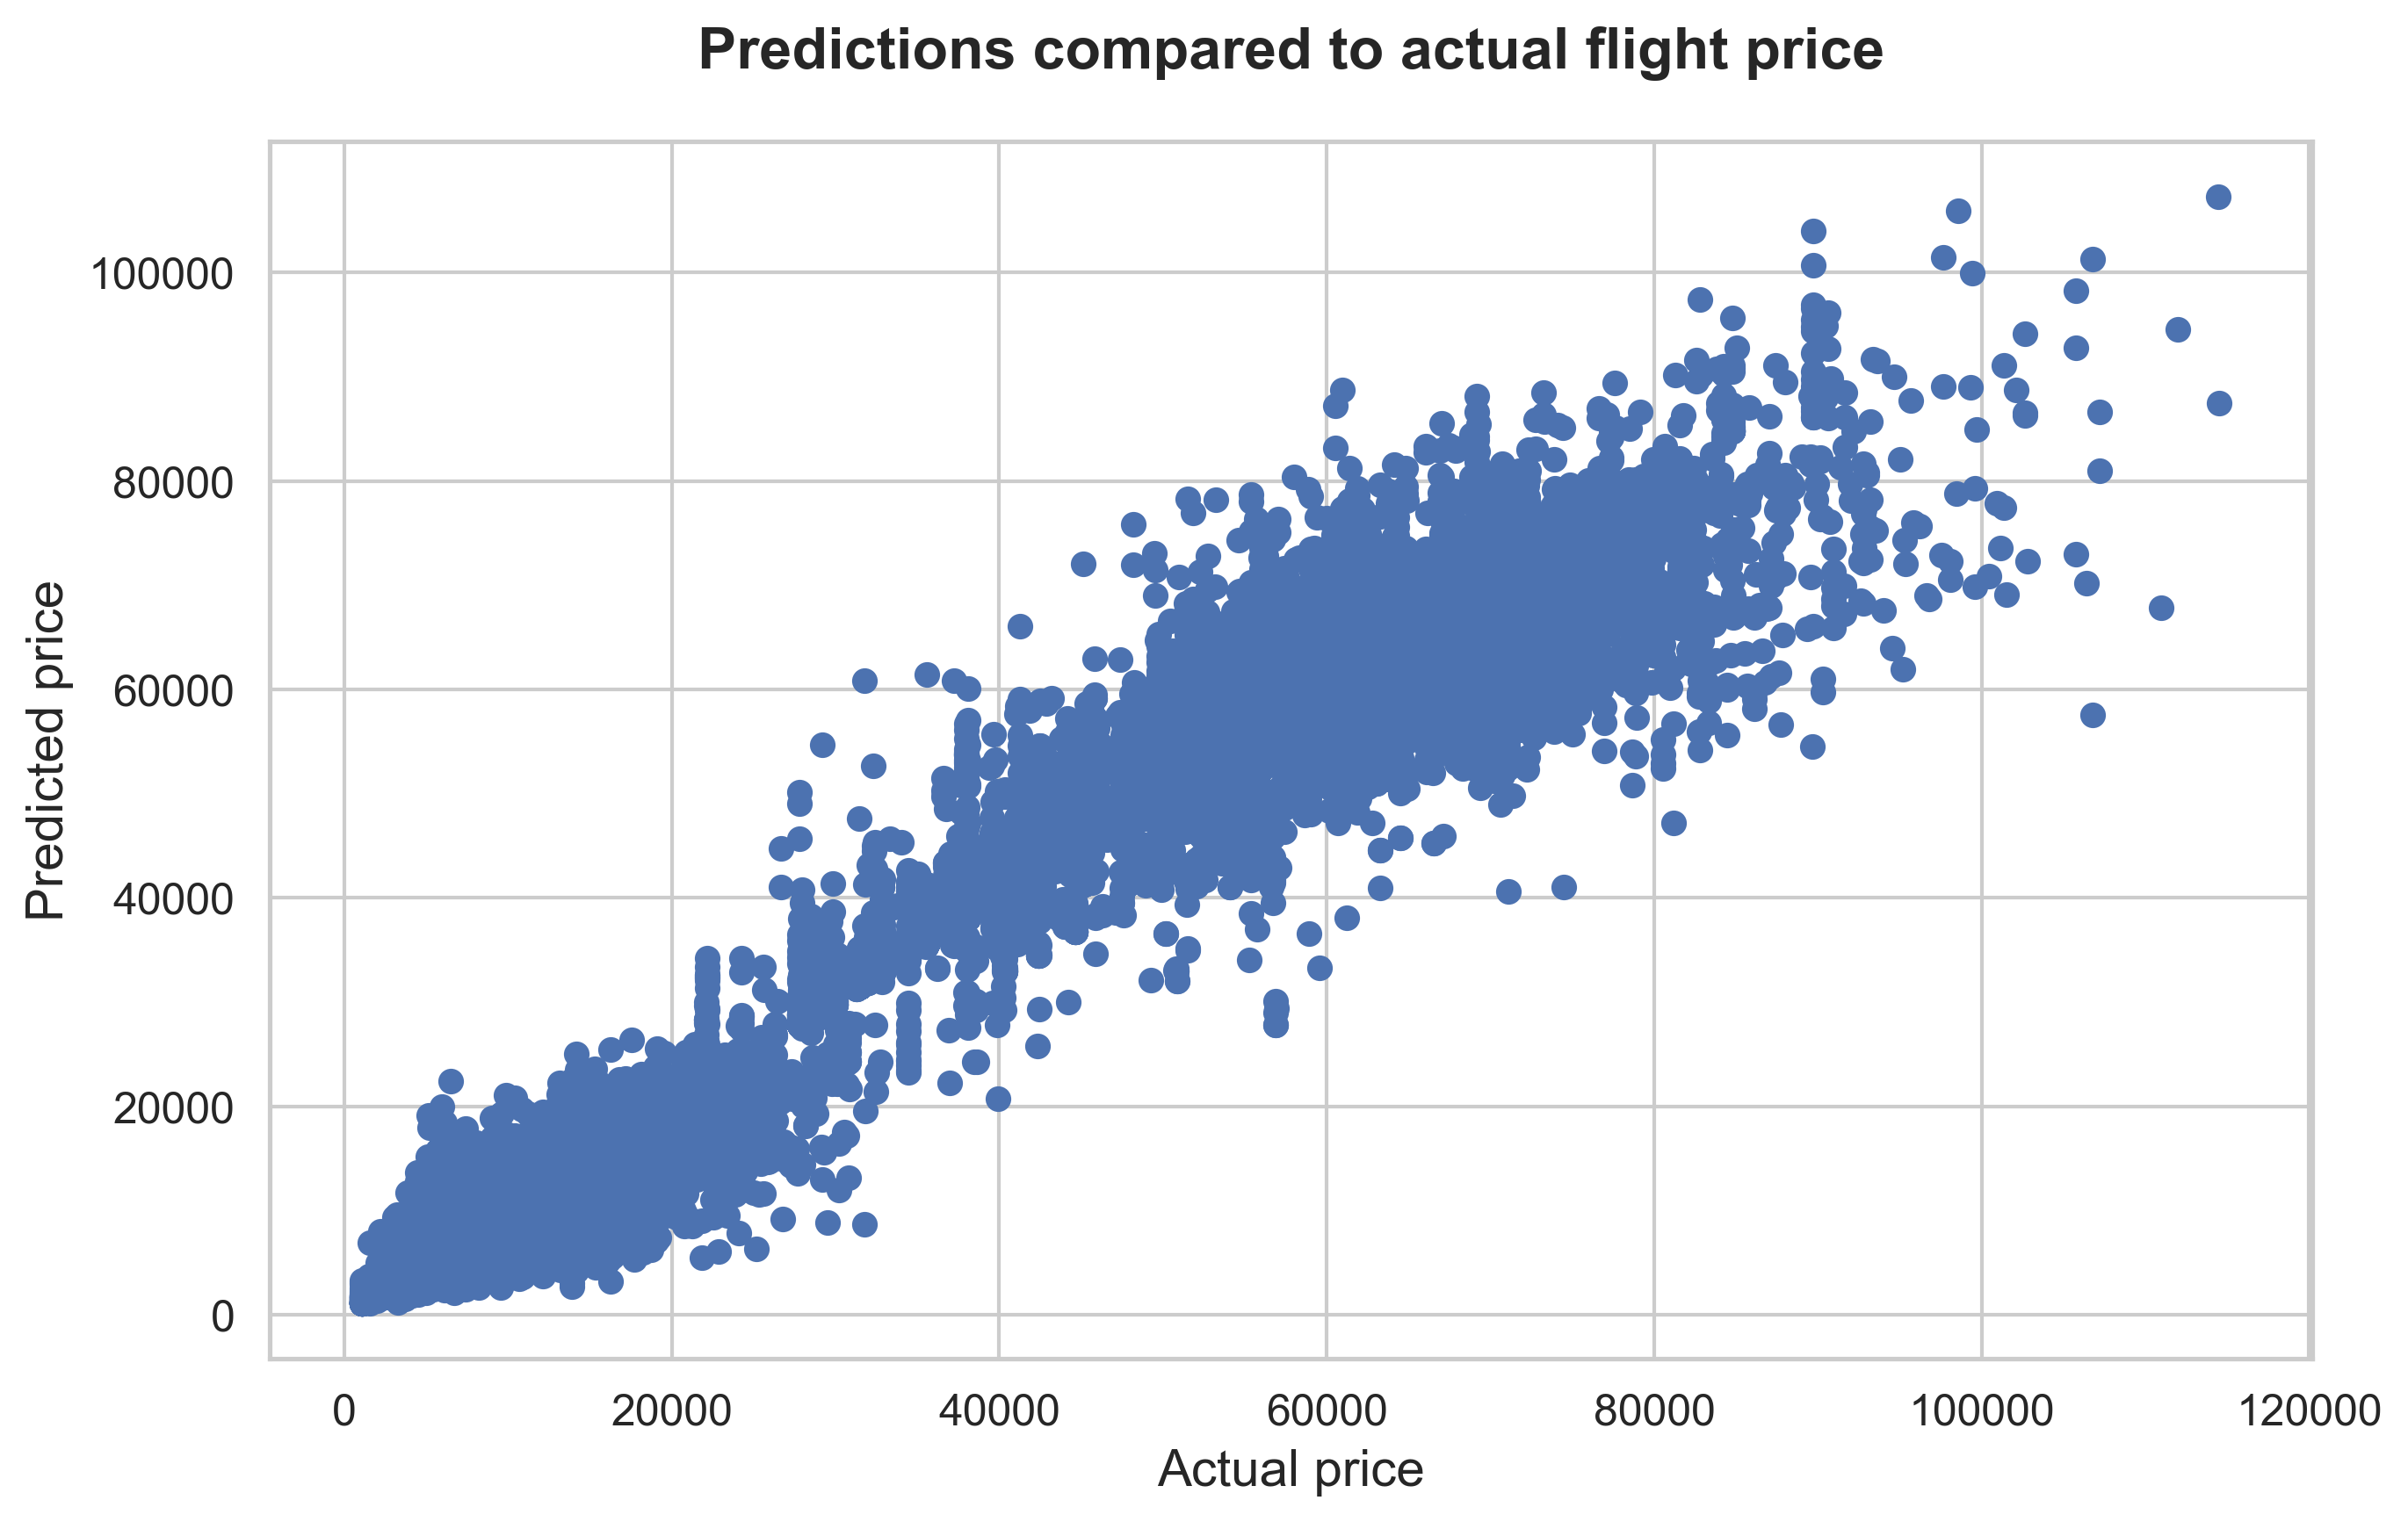

In [20]:
# Plot actual price compared to predicted price
plt.scatter(y_test, y_pred)
plt.title('Predictions compared to actual flight price', fontweight='bold', pad =20)
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.savefig('Images/predictions_actual', dpi=300)
plt.show()

In [21]:
# As can be seen in the scatterplot, the variance is relatively low, which indicates that the model is performing relatively well

In [22]:
# Understand the importances of the different features

importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

print("Feature importance ranking:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]}")

Feature importance ranking:
class: 0.8796427824063223
duration: 0.057743666828194075
days_left: 0.018604842114644065
airline_Air_India: 0.0055724615509455165
airline_Vistara: 0.004376504230473941
source_Delhi: 0.004061090626582859
destination_Delhi: 0.003421927946332676
source_Mumbai: 0.0022528659951600643
destination_Mumbai: 0.0019528210052933118
destination_Kolkata: 0.0017906010226243743
stops: 0.001751238338589629
source_Kolkata: 0.0016953226998752814
destination_Hyderabad: 0.0015764015220833057
arrival_time_Evening: 0.00143098172696148
source_Hyderabad: 0.001195999568808328
destination_Bangalore: 0.0011782963887128886
source_Bangalore: 0.0011485740738858318
arrival_time_Night: 0.0011282531685296061
departure_time_Evening: 0.0011066126632749904
arrival_time_Afternoon: 0.001037487128196267
source_Chennai: 0.0008605926168139316
destination_Chennai: 0.0008564725044642955
departure_time_Morning: 0.0008485503441073358
departure_time_Afternoon: 0.0008317966781972492
departure_time_Early_M

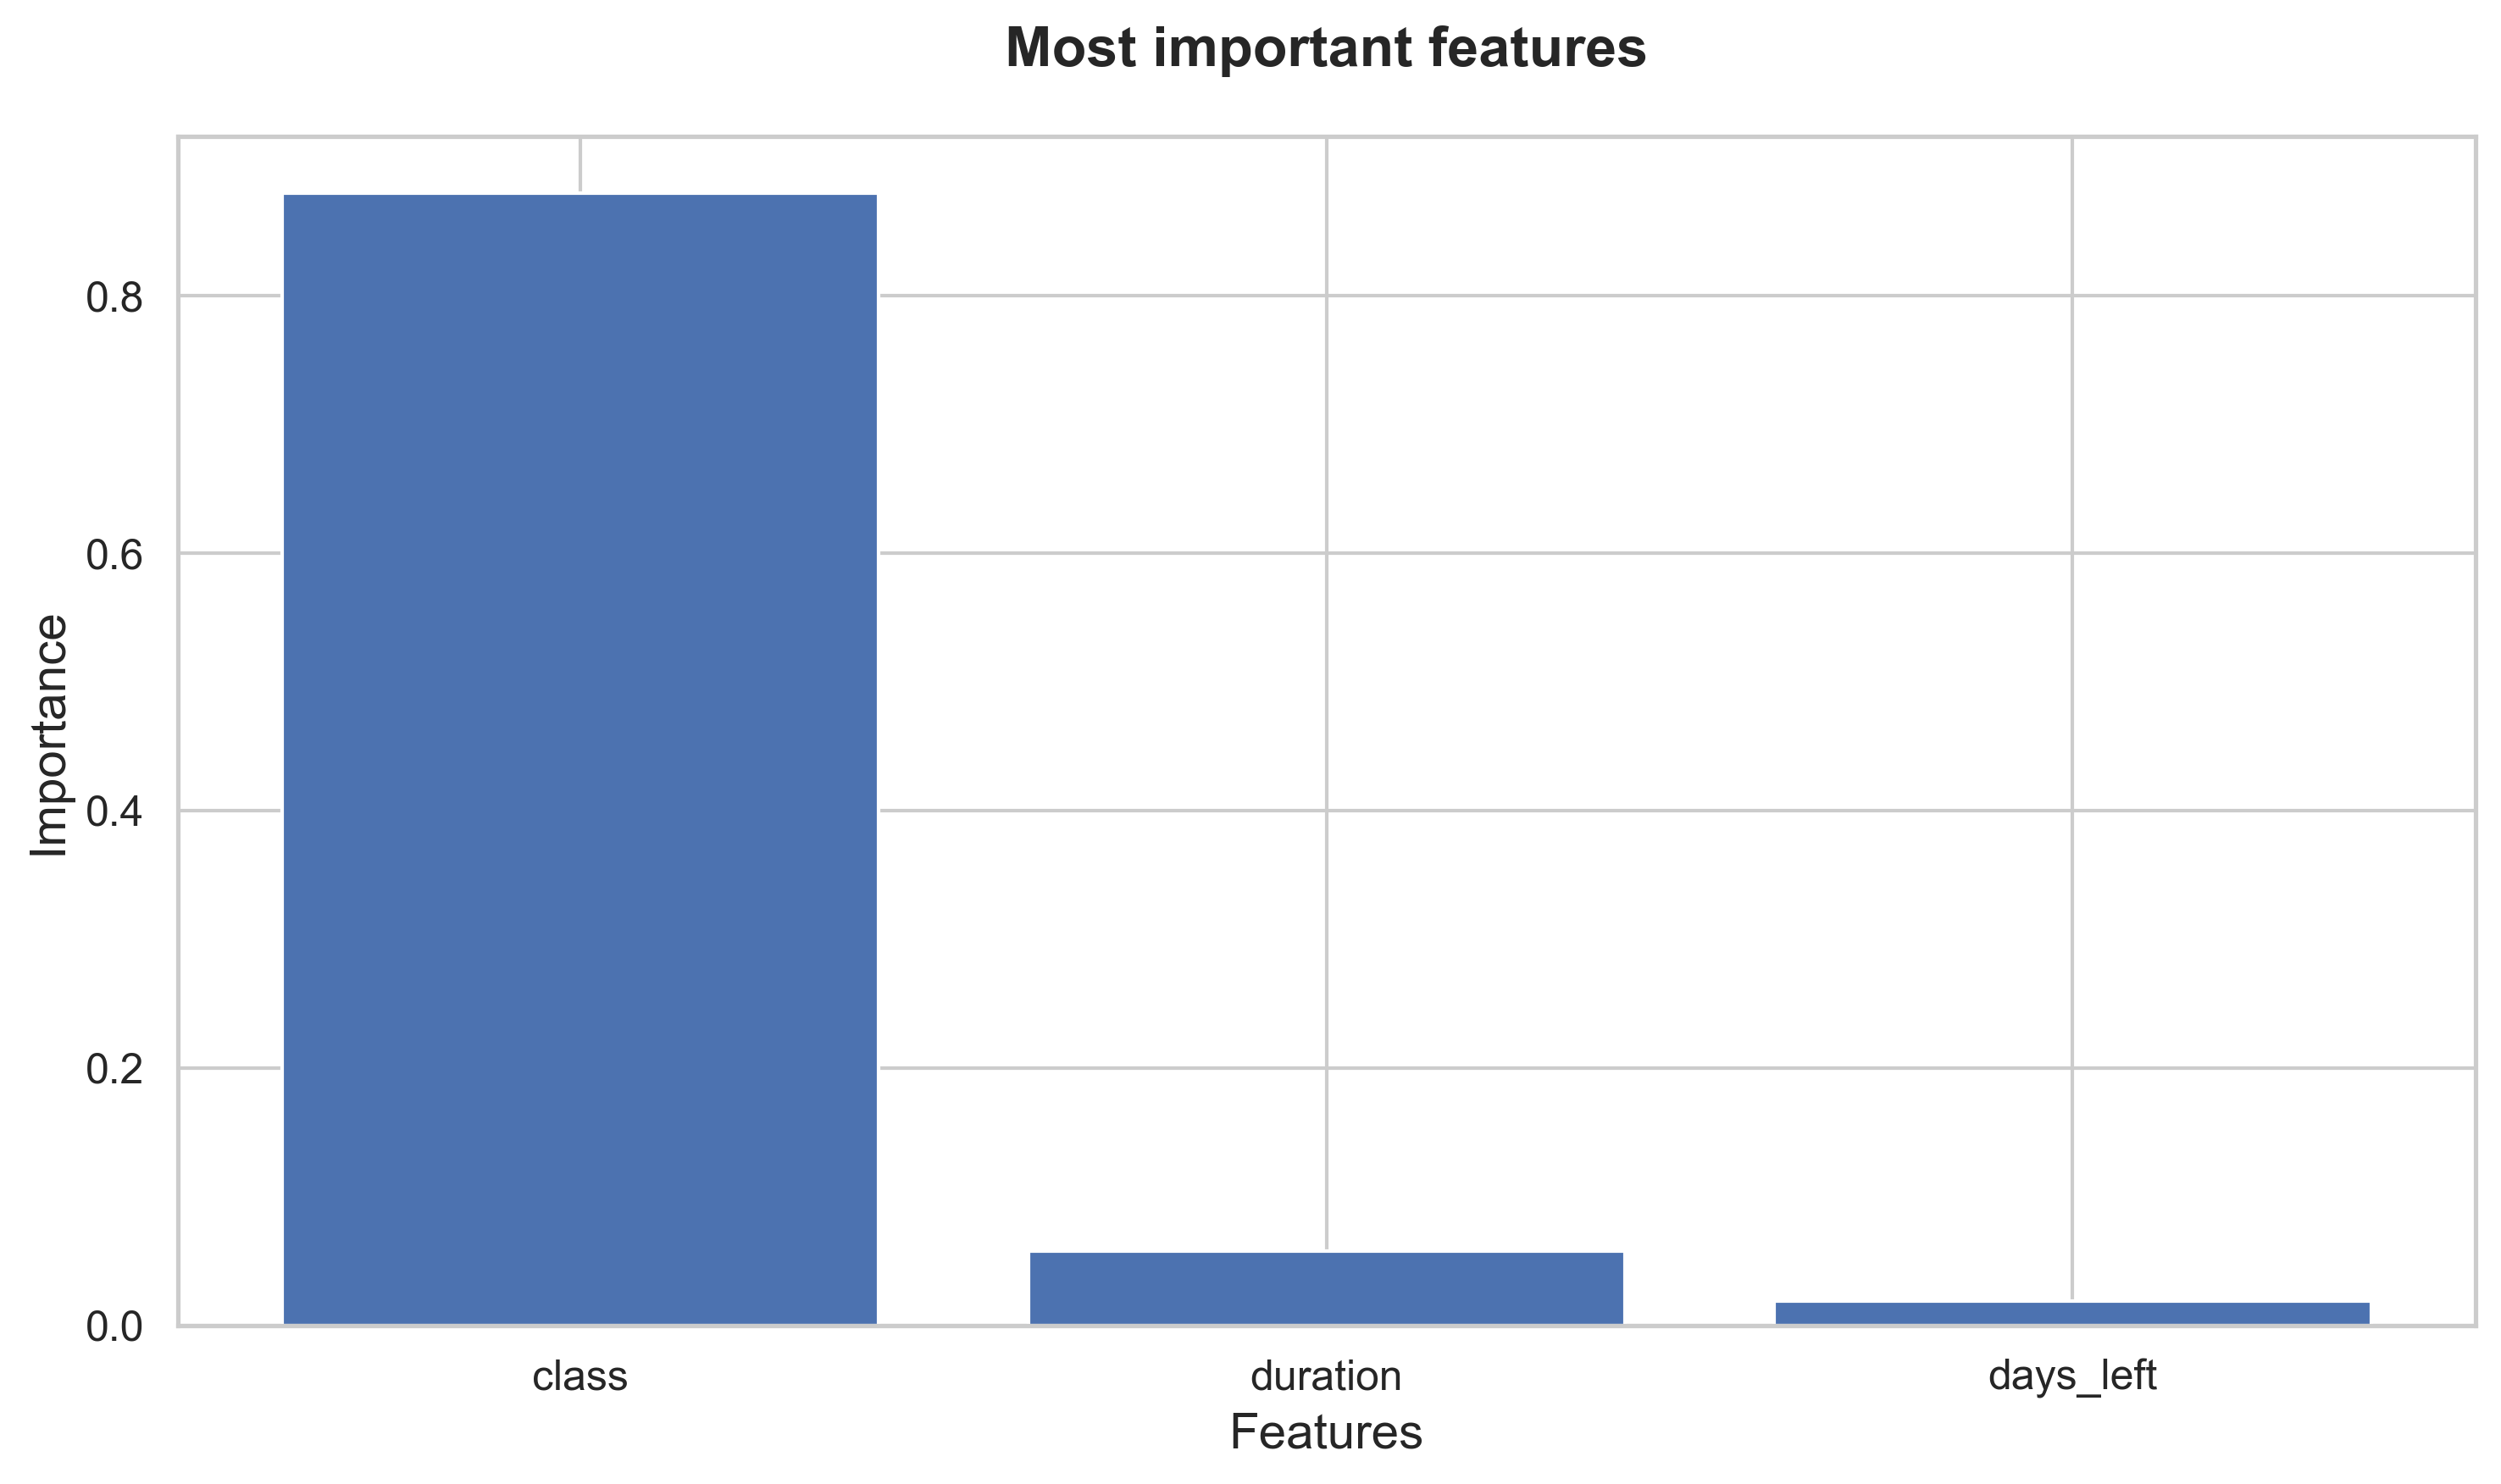

In [23]:
# Visualize top 3 features
top_3_indices = indices[:3]
top_3_features = feature_names[top_3_indices]
top_3_importances = importances[top_3_indices]

plt.bar(range(3), top_3_importances)
plt.xticks(range(3), top_3_features)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Most important features', fontweight='bold', pad =20)
plt.tight_layout()
plt.savefig('Images/most_important_features', dpi=300)
plt.show()